In [207]:
import os
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib import cm
from shapely.geometry import Point
from sklearn import cluster
from sklearn.decomposition import PCA
%matplotlib inline

# Thursday, July 13
## Clean up website viz data.
1. Collect all weekday data from database (June 26-June 30 & July 10-Present)
2. Calculate mean values per camera at 5 minute intervals.
3. Clean up the d3 viz a bit (add title, improve spacing)

In [2]:
df = pd.read_csv('./weekdayoutput.csv')
df.date = pd.to_datetime(df.date, errors='coerce')
df = df[~df.date.isnull()]
print df.dtypes
print df.date.dt.normalize().unique()
df['min5'] = df.date.apply(lambda dt: datetime.datetime(
        1, 1, 1, dt.hour, 5*(dt.minute//5)))
df.head()

/Users/JordanVani/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


cam_id              int64
date       datetime64[ns]
cam_dir            object
count               int64
imtime             object
dtype: object
['2017-06-27T00:00:00.000000000' '2017-06-28T00:00:00.000000000'
 '2017-06-29T00:00:00.000000000' '2017-06-30T00:00:00.000000000'
 '2017-07-10T00:00:00.000000000' '2017-07-11T00:00:00.000000000'
 '2017-07-12T00:00:00.000000000' '2017-07-13T00:00:00.000000000']


,cam_id,date,cam_dir,count,imtime,min5
0,368,2017-06-27 20:09:22,S,1,NaN,0001-01-01 20:05:00
1,360,2017-06-27 20:09:23,NaN,1,NaN,0001-01-01 20:05:00
2,361,2017-06-27 20:09:23,N,2,NaN,0001-01-01 20:05:00
3,550,2017-06-27 20:09:23,N,2,NaN,0001-01-01 20:05:00
4,940,2017-06-27 20:09:23,S,1,NaN,0001-01-01 20:05:00


In [3]:
df_avg = pd.DataFrame(df.groupby(['cam_id', 'min5'])['count'].mean()).reset_index()
df_avg.rename(columns={'cam_id': 'cam', 'min5': 'date'}, inplace=True)
df_avg.head()

,cam,date,count
0,112,0001-01-01 00:00:00,0.0
1,112,0001-01-01 00:05:00,0.0
2,112,0001-01-01 00:10:00,0.0
3,112,0001-01-01 00:15:00,0.0
4,112,0001-01-01 00:20:00,0.0


In [4]:
df_avg.to_csv('./weekdayavg.csv')

## Add Zipcode and Boro data to camera data.

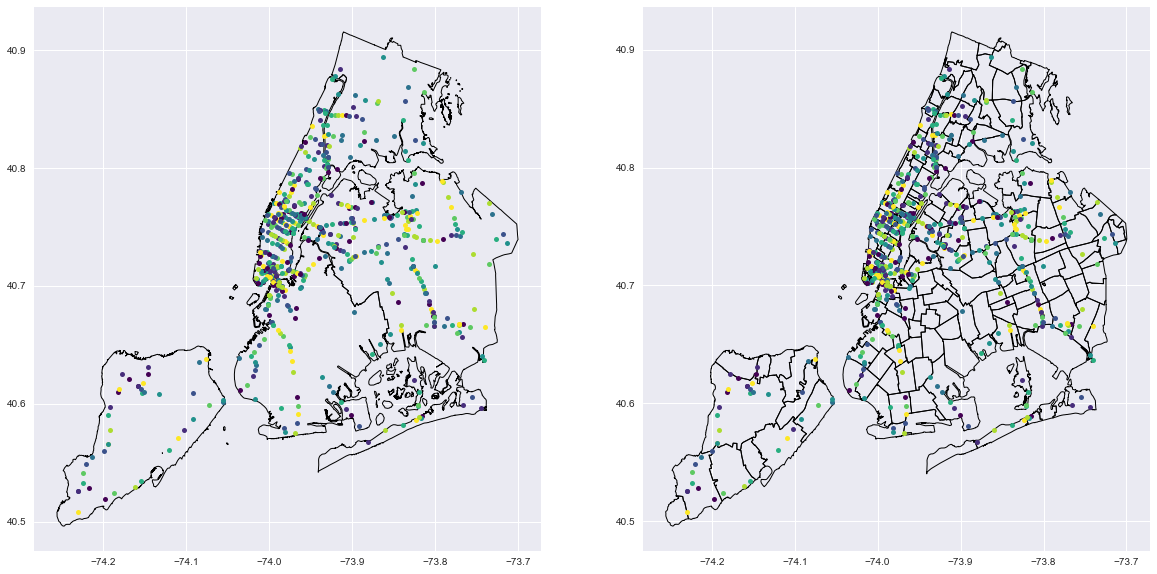

In [5]:
df = pd.read_csv('./cameras.csv')
geometry = [Point(xy) for xy in zip(df.long, df.lat)]
cams = gpd.GeoDataFrame(df['cam_id'], crs={'init': 'epsg:4326'}, geometry=geometry)

nyc = gpd.read_file("../June_4/nybb_17b/nybb.shp")
nyc = nyc.to_crs({'init': 'epsg:4326'})

zc = gpd.read_file("./ZIP_CODE/ZIP_CODE_040114.shp")
zc = zc.to_crs({'init': 'epsg:4326'})

cams_boro = gpd.sjoin(cams, nyc, how="left")[['cam_id', 'geometry', 'BoroName']]
cams_zip = gpd.sjoin(cams, zc, how="left").drop_duplicates(
    subset='cam_id', keep='first')[['cam_id', 'ZIPCODE']]
cams = cams_boro.merge(cams_zip, on='cam_id').fillna('Bridge')

fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
nyc.plot(ax=ax1, facecolor='none')
cams.plot(ax=ax1, markersize=5, cmap='viridis')
zc.plot(ax=ax2, facecolor='none')
cams.plot(ax=ax2, markersize=5, cmap='viridis')

In [6]:
cams.drop('geometry', axis=1).to_csv('cameras_info.csv')

In [7]:
# with psycopg2.connect("dbname='dot_pedestrian_counts' user='jmv423'") as conn:
#     with conn.cursor() as cursor: 
#         with open("cameras_info.csv" , "r") as data:
#             data_reader = csv.reader(data)
#             data_reader.next()
#             for row in data_reader:
#                 cursor.execute("""
#                 UPDATE cameras
#                 SET boro = '{}', zipcode = '{}'
#                 WHERE cam_id = '{}'""".format(row[2], row[3], row[1]))                            
#         cursor.execute("""SELECT * FROM cameras""")
#         print cursor.fetchall()

## Clustering Cameras By Weekday Averages

In [15]:
cams_ = pd.read_csv("./cameras.csv")
manhattan_cams = cams_[(cams_['people'] == 1) & (cams_['boro'] == 'Manhattan')]

peds = pd.read_csv("./peds.csv")
peds.date = pd.to_datetime(peds.date, errors='coerce')
peds = peds[~peds.date.isnull()]
peds['min10'] = peds.date.apply(lambda dt: datetime.datetime(
        1, 1, 1, dt.hour, 10*(dt.minute//10)))
peds.set_index('date', inplace=True)
print peds.index.normalize().unique()

DatetimeIndex(['2017-06-27', '2017-06-28', '2017-06-29', '2017-06-30',
               '2017-07-01', '2017-07-02', '2017-07-03', '2017-07-04',
               '2017-07-05', '2017-07-06', '2017-07-07', '2017-07-08',
               '2017-07-09', '2017-07-10', '2017-07-11', '2017-07-12',
               '2017-07-13'],
              dtype='datetime64[ns]', name=u'date', freq=None)


In [16]:
peds_weekday = peds[(peds.index < '2017-07-01') | (peds.index > '2017-07-10')]
print peds_weekday.index.normalize().unique()

DatetimeIndex(['2017-06-27', '2017-06-28', '2017-06-29', '2017-06-30',
               '2017-07-10', '2017-07-11', '2017-07-12', '2017-07-13'],
              dtype='datetime64[ns]', name=u'date', freq=None)


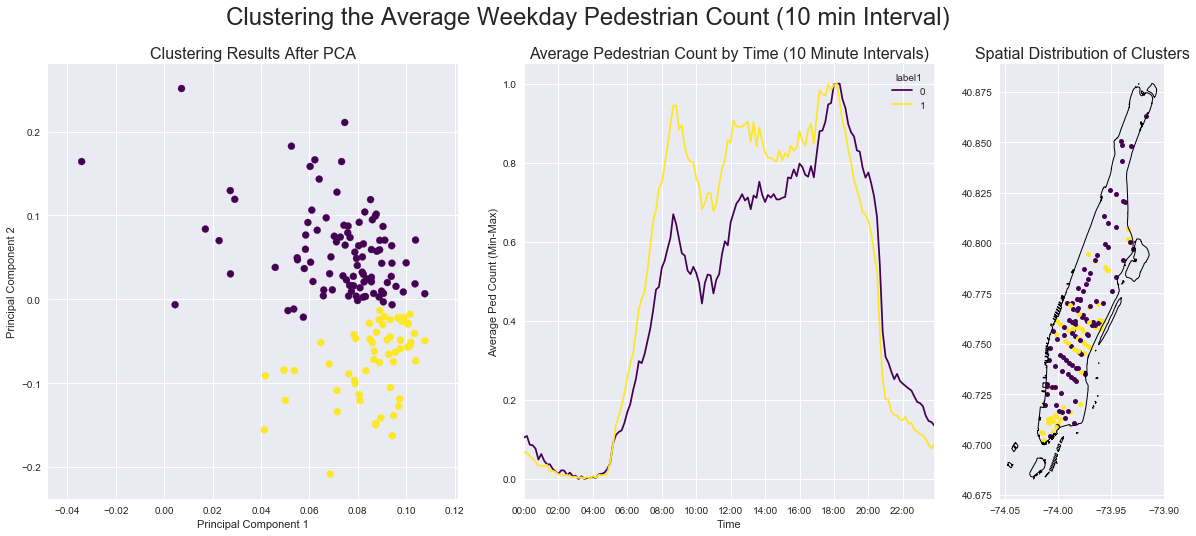

In [305]:
peds_weekday_avg = pd.DataFrame(peds_weekday.groupby(['cam_id', 'min10'])['count'].mean())
peds_weekday_avg = peds_weekday_avg.unstack(1,)
peds_weekday_avg.columns = peds_weekday_avg.columns.droplevel()
peds_weekday_avg = peds_weekday_avg.T
peds_weekday_avg = (peds_weekday_avg-peds_weekday_avg.min())/(peds_weekday_avg.max()-peds_weekday_avg.min())
peds_weekday_avg = peds_weekday_avg.T
peds_weekday_avg.columns = range(len(peds_weekday_avg.columns))
peds_weekday_avg.dropna(inplace=True)
peds_weekday_avg = peds_weekday_avg[peds_weekday_avg.index.isin(manhattan_cams.cam_id.unique())]

pca = PCA(n_components=2)
pca.fit(peds_weekday_avg.T)

# clust = cluster.DBSCAN(eps=0.016, min_samples=10).fit(zip(pca.components_[0], pca.components_[1]))
# TRY THIS ONE
# clust = cluster.KMeans(n_clusters=4).fit(zip(pca.components_[0], pca.components_[1]))
# clust = cluster.AffinityPropagation(damping=0.86365).fit(zip(pca.components_[0], pca.components_[1]))
# clust = cluster.MeanShift().fit(zip(pca.components_[0], pca.components_[1]))
# TRY THIS ONE
clust = cluster.SpectralClustering(n_clusters=2, affinity="nearest_neighbors").fit(zip(pca.components_[0], pca.components_[1]))

peds_weekday_avg['label1'] = clust.labels_

fig, [ax1, ax2, ax3] = plt.subplots(nrows=1, ncols=3, figsize=(20, 8), gridspec_kw = {'width_ratios':[2.5, 2.5, 1]})
fig.suptitle("Clustering the Average Weekday Pedestrian Count (10 min Interval)", fontsize=24)

ax1.scatter(pca.components_[0], pca.components_[1], c=clust.labels_, label=clust.labels_, cmap='viridis')
ax1.set_xlabel("Principal Component 1")
ax1.set_ylabel("Principal Component 2")
ax1.set_title("Clustering Results After PCA", fontsize=16)

g_avg = peds_weekday_avg.groupby('label1').mean().T
g_avg = (g_avg-g_avg.min()) / (g_avg.max()-g_avg.min())
g_avg.plot(cmap='viridis', ax=ax2)
ax2.set_ylabel("Average Ped Count In Cluster (Min-Max)")
ax2.set_title("Average Pedestrian Count by Time (10 Minute Intervals)", fontsize=16)
ax2.set_xlabel("Time")
ax2.set_ylabel("Average Ped Count (Min-Max)")
ax2.set_xticks(range(144)[0::12])
ax2.set_xticklabels(map(lambda x: x.strftime("%H:%M"), pd.to_datetime(np.linspace(pd.Timestamp('2017-07-08').value, pd.Timestamp('2017-07-09').value, 145))[0::12]))

cams.merge(peds_weekday_avg[['label1']].reset_index(), how='right').plot(
    column='label1', ax=ax3, markersize=5, cmap='viridis')
nyc[nyc.BoroName == 'Manhattan'].plot(ax=ax3, facecolor='none')
ax3.set_title("Spatial Distribution of Clusters", fontsize=16)

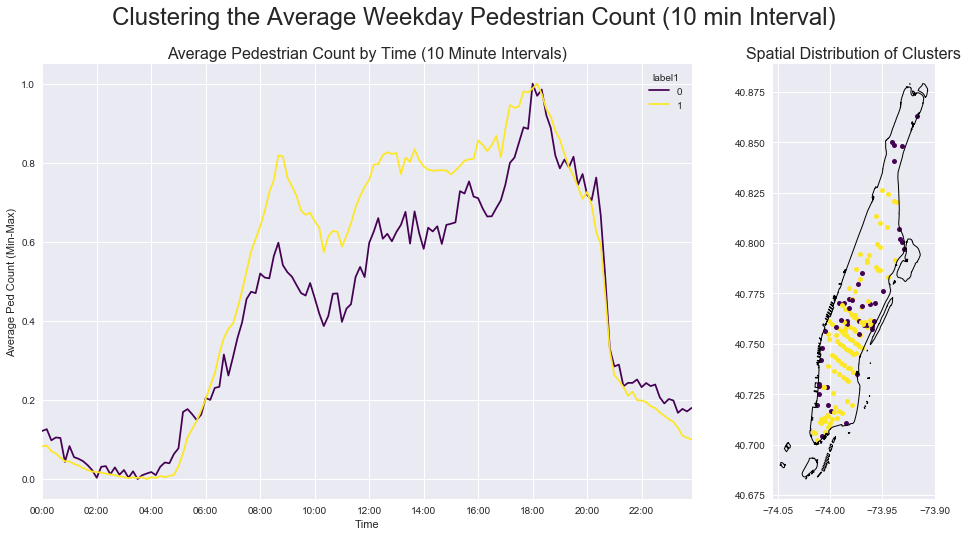

In [46]:
clust = cluster.KMeans(n_clusters=2).fit(peds_weekday_avg.drop('label1', axis=1))
# clust = cluster.SpectralClustering(n_clusters=2, affinity="nearest_neighbors").fit(peds_weekday_avg.drop('label1', axis=1))
# clust = cluster.AffinityPropagation(damping=0.999999999999999).fit(peds_weekday_avg.drop('label1', axis=1))

peds_weekday_avg['label1'] = clust.labels_

fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(16, 8), gridspec_kw = {'width_ratios':[4, 1]})
fig.suptitle("Clustering the Average Weekday Pedestrian Count (10 min Interval)", fontsize=24)

g_avg = peds_weekday_avg.groupby('label1').mean().T
g_avg = (g_avg-g_avg.min()) / (g_avg.max()-g_avg.min())
g_avg.plot(cmap='viridis', ax=ax1)
ax1.set_ylabel("Average Ped Count In Cluster (Min-Max)")
ax1.set_title("Average Pedestrian Count by Time (10 Minute Intervals)", fontsize=16)
ax1.set_xlabel("Time")
ax1.set_ylabel("Average Ped Count (Min-Max)")
ax1.set_xticks(range(144)[0::12])
ax1.set_xticklabels(map(lambda x: x.strftime("%H:%M"), pd.to_datetime(np.linspace(pd.Timestamp('2017-07-08').value, pd.Timestamp('2017-07-09').value, 145))[0::12]))

cams.merge(peds_weekday_avg[['label1']].reset_index(), how='right').plot(
    column='label1', ax=ax2, markersize=5, cmap='viridis')
nyc[nyc.BoroName == 'Manhattan'].plot(ax=ax2, facecolor='none')
ax2.set_title("Spatial Distribution of Clusters", fontsize=16)

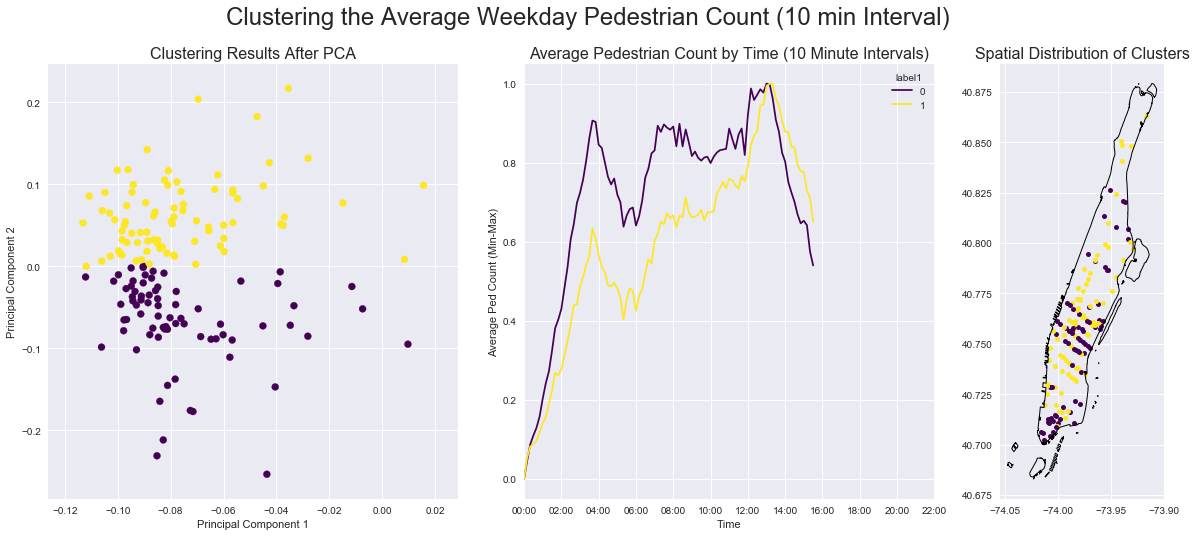

In [304]:
peds_weekday_avg = pd.DataFrame(peds_weekday.groupby(['cam_id', 'min10'])['count'].mean())
peds_weekday_avg = peds_weekday_avg.unstack(1,)
peds_weekday_avg.columns = peds_weekday_avg.columns.droplevel()
peds_weekday_avg = peds_weekday_avg[range(30, 124)]
peds_weekday_avg = peds_weekday_avg.T
peds_weekday_avg = (peds_weekday_avg-peds_weekday_avg.min())/(peds_weekday_avg.max()-peds_weekday_avg.min())
peds_weekday_avg = peds_weekday_avg.T
peds_weekday_avg.columns = range(len(peds_weekday_avg.columns))
peds_weekday_avg.dropna(inplace=True)
peds_weekday_avg = peds_weekday_avg[peds_weekday_avg.index.isin(manhattan_cams.cam_id.unique())]


pca = PCA(n_components=2)
pca.fit(peds_weekday_avg.T)

# clust = cluster.DBSCAN(eps=0.016, min_samples=10).fit(zip(pca.components_[0], pca.components_[1]))
# TRY THIS ONE
# clust = cluster.KMeans(n_clusters=4).fit(zip(pca.components_[0], pca.components_[1]))
# clust = cluster.AffinityPropagation(damping=0.86365).fit(zip(pca.components_[0], pca.components_[1]))
# clust = cluster.MeanShift().fit(zip(pca.components_[0], pca.components_[1]))
# TRY THIS ONE
clust = cluster.SpectralClustering(n_clusters=2, affinity="nearest_neighbors").fit(zip(pca.components_[0], pca.components_[1]))

peds_weekday_avg['label1'] = clust.labels_

fig, [ax1, ax2, ax3] = plt.subplots(nrows=1, ncols=3, figsize=(20, 8), gridspec_kw = {'width_ratios':[2.5, 2.5, 1]})
fig.suptitle("Clustering the Average Weekday Pedestrian Count (10 min Interval)", fontsize=24)

ax1.scatter(pca.components_[0], pca.components_[1], c=clust.labels_, label=clust.labels_, cmap='viridis')
ax1.set_xlabel("Principal Component 1")
ax1.set_ylabel("Principal Component 2")
ax1.set_title("Clustering Results After PCA", fontsize=16)

g_avg = peds_weekday_avg.groupby('label1').mean().T
g_avg = (g_avg-g_avg.min()) / (g_avg.max()-g_avg.min())
g_avg.plot(cmap='viridis', ax=ax2)
ax2.set_ylabel("Average Ped Count In Cluster (Min-Max)")
ax2.set_title("Average Pedestrian Count by Time (10 Minute Intervals)", fontsize=16)
ax2.set_xlabel("Time")
ax2.set_ylabel("Average Ped Count (Min-Max)")
ax2.set_xticks(range(144)[0::12])
ax2.set_xticklabels(map(lambda x: x.strftime("%H:%M"), pd.to_datetime(np.linspace(pd.Timestamp('2017-07-08').value, pd.Timestamp('2017-07-09').value, 145))[0::12]))

cams.merge(peds_weekday_avg[['label1']].reset_index(), how='right').plot(
    column='label1', ax=ax3, markersize=5, cmap='viridis')
nyc[nyc.BoroName == 'Manhattan'].plot(ax=ax3, facecolor='none')
ax3.set_title("Spatial Distribution of Clusters", fontsize=16)

## Anomaly Detection

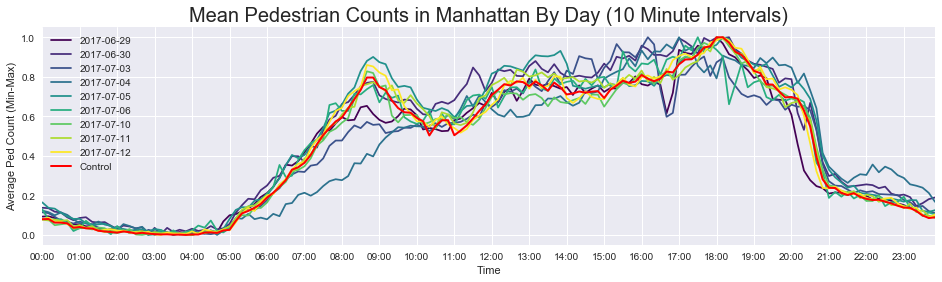

In [11]:
peds_control = peds[(peds.index > '2017-07-10')]

peds_control_avg = pd.DataFrame(peds_control.groupby(['cam_id', 'min10'])['count'].mean())
peds_control_avg = peds_control_avg.unstack(1,)
peds_control_avg.columns = peds_control_avg.columns.droplevel()
peds_control_avg = peds_control_avg.T
peds_control_avg = (peds_control_avg-peds_control_avg.min())/(peds_control_avg.max()-peds_control_avg.min())
peds_control_avg = peds_control_avg.T
peds_control_avg.columns = range(len(peds_control_avg.columns))
peds_control_avg.dropna(inplace=True)
peds_control_avg = peds_control_avg[peds_control_avg.index.isin(manhattan_cams.cam_id.unique())]
peds_control_avg = peds_control_avg.mean(axis=0)
peds_control_avg = (peds_control_avg-peds_control_avg.min())/(peds_control_avg.max()-peds_control_avg.min())

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(16, 4))
dates = ['2017-06-29', '2017-06-30', '2017-07-03', '2017-07-04',
         '2017-07-05', '2017-07-06', '2017-07-10', 
         '2017-07-11', '2017-07-12']

colors = [cm.viridis(x) for x in np.linspace(0., 1., len(dates))]

for color, idx in zip(colors, range(len(dates))):
    day = peds[(peds.index.month == int(dates[idx][5:7])) & (peds.index.day == int(dates[idx][-2:]))]
    day_avg = pd.DataFrame(day.groupby(['cam_id', 'min10'])['count'].mean())
    day_avg = day_avg.unstack(1,)
    day_avg.columns = day_avg.columns.droplevel()
    day_avg = day_avg.T
    day_avg = (day_avg-day_avg.min())/(day_avg.max()-day_avg.min())
    day_avg = day_avg.T
    day_avg.columns = range(len(day_avg.columns))
    day_avg.dropna(inplace=True)
    day_avg = day_avg[day_avg.index.isin(manhattan_cams.cam_id.unique())]
    day_avg = day_avg.mean(axis=0)
    day_avg = (day_avg-day_avg.min())/(day_avg.max()-day_avg.min()) 
    day_avg.plot(ax=ax1, label=dates[idx], c=color)
    
peds_control_avg.plot(ax=ax1, label='Control', lw=2, c='r')
ax1.set_title("Mean Pedestrian Counts in Manhattan By Day (10 Minute Intervals)", fontsize=20)
ax1.set_xlabel("Time")
ax1.set_ylabel("Average Ped Count (Min-Max)")
ax1.set_xticks(range(144)[0::6])
ax1.set_xticklabels(map(lambda x: x.strftime("%H:%M"), pd.to_datetime(np.linspace(pd.Timestamp('2017-07-08').value, pd.Timestamp('2017-07-09').value, 145))[0::6]))
ax1.legend()

## Weekend v. Weekday

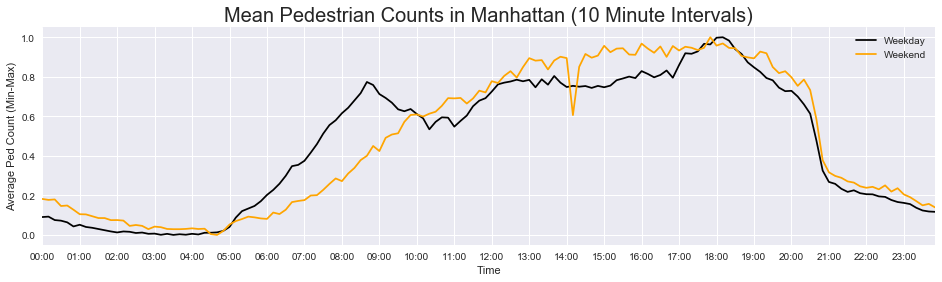

In [12]:
peds_weekday = peds[(peds.index < '2017-07-01') | (peds.index > '2017-07-10')]
peds_weekday = pd.DataFrame(peds_weekday.groupby(['cam_id', 'min10'])['count'].mean())
peds_weekday = peds_weekday.unstack(1,)
peds_weekday.columns = peds_weekday.columns.droplevel()
peds_weekday = peds_weekday.T
peds_weekday = (peds_weekday-peds_weekday.min())/(peds_weekday.max()-peds_weekday.min())
peds_weekday = peds_weekday.T
peds_weekday.columns = range(len(peds_weekday.columns))
peds_weekday.dropna(inplace=True)
peds_weekday = peds_weekday[peds_weekday.index.isin(manhattan_cams.cam_id.unique())]
peds_weekday = peds_weekday.mean(axis=0)
peds_weekday = (peds_weekday-peds_weekday.min())/(peds_weekday.max()-peds_weekday.min())

peds_weekend = peds[(peds.index > '2017-07-08') & (peds.index < '2017-07-10')]
peds_weekend = pd.DataFrame(peds_weekend.groupby(['cam_id', 'min10'])['count'].mean())
peds_weekend = peds_weekend.unstack(1,)
peds_weekend.columns = peds_weekend.columns.droplevel()
peds_weekend = peds_weekend.T
peds_weekend = (peds_weekend-peds_weekend.min())/(peds_weekend.max()-peds_weekend.min())
peds_weekend = peds_weekend.T
peds_weekend.columns = range(len(peds_weekend.columns))
peds_weekend.dropna(inplace=True)
peds_weekend = peds_weekend[peds_weekend.index.isin(manhattan_cams.cam_id.unique())]
peds_weekend = peds_weekend.mean(axis=0)
peds_weekend = (peds_weekend-peds_weekend.min())/(peds_weekend.max()-peds_weekend.min())

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(16, 4))
peds_weekday.plot(ax=ax1, c='k', label='Weekday')
peds_weekend.plot(ax=ax1, c='orange', label='Weekend')
ax1.set_title("Mean Pedestrian Counts in Manhattan (10 Minute Intervals)", fontsize=20)
ax1.set_xlabel("Time")
ax1.set_ylabel("Average Ped Count (Min-Max)")
ax1.set_xticks(range(144)[0::6])
ax1.set_xticklabels(map(lambda x: x.strftime("%H:%M"), pd.to_datetime(np.linspace(pd.Timestamp('2017-07-08').value, pd.Timestamp('2017-07-09').value, 145))[0::6]))
ax1.legend()

## Weekend and 4th of July 

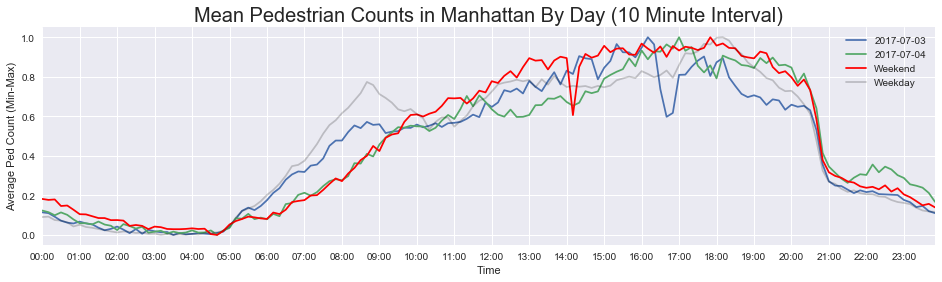

In [13]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(16, 4))

dates_= ['2017-07-03', '2017-07-04',]

colors = [cm.viridis(x) for x in np.linspace(0., 1., len(dates))]
    
for color, idx in zip(colors, range(len(dates_))):
    day = peds[(peds.index.month == int(dates_[idx][5:7])) & (peds.index.day == int(dates_[idx][-2:]))]
    day_avg = pd.DataFrame(day.groupby(['cam_id', 'min10'])['count'].mean())
    day_avg = day_avg.unstack(1,)
    day_avg.columns = day_avg.columns.droplevel()
    day_avg = day_avg.T
    day_avg = (day_avg-day_avg.min())/(day_avg.max()-day_avg.min())
    day_avg = day_avg.T
    day_avg.columns = range(len(day_avg.columns))
    day_avg.dropna(inplace=True)
    day_avg = day_avg[day_avg.index.isin(manhattan_cams.cam_id.unique())]
    day_avg = day_avg.mean(axis=0)
    day_avg = (day_avg-day_avg.min())/(day_avg.max()-day_avg.min()) 
    day_avg.plot(ax=ax1, label=dates_[idx])
    
peds_weekend.plot(ax=ax1, c='r', label='Weekend')
peds_weekday.plot(ax=ax1, c='k', label='Weekday', alpha=0.2)
ax1.set_title("Mean Pedestrian Counts in Manhattan By Day (10 Minute Interval)", fontsize=20)
ax1.set_xlabel("Time")
ax1.set_ylabel("Average Ped Count (Min-Max)")
ax1.set_xticks(range(144)[0::6])
ax1.set_xticklabels(map(lambda x: x.strftime("%H:%M"), pd.to_datetime(np.linspace(pd.Timestamp('2017-07-08').value, pd.Timestamp('2017-07-09').value, 145))[0::6]))
ax1.legend()

# Turnstile Counts

In [117]:
mta = pd.read_csv('./turnstile_170708.txt')
mta.DATE.unique()

array(['07/01/2017', '07/02/2017', '07/03/2017', '07/04/2017',
       '07/05/2017', '07/06/2017', '07/07/2017'], dtype=object)

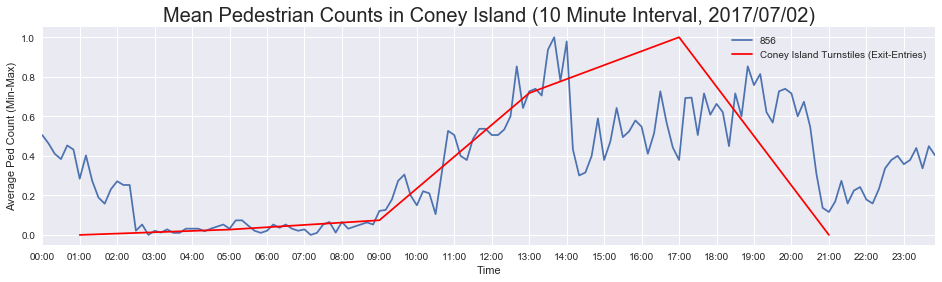

In [287]:
DAY = 2 # 1-7

ci = mta[mta['STATION'] == 'CONEY IS-STILLW']
ci_sat = ci[ci['DATE'] == '07/0{}/2017'.format(str(DAY))].groupby('TIME').mean()

ci_sat_mm = (ci_sat-ci_sat.min())/(ci_sat.max()-ci_sat.min())
ci_sat_mm = ci_sat_mm.T
ci_sat_mm.columns = [6, 30, 54, 78, 102, 126]
ci_sat_mm = ci_sat_mm.T
ci_sat_mm.columns = ['ENTRIES', 'EXITS']
ci_sat_mm['DIFF_MM'] = ci_sat_mm.EXITS - ci_sat_mm.ENTRIES
ci_sat_mm = (ci_sat_mm-ci_sat_mm.min())/(ci_sat_mm.max()-ci_sat_mm.min())
ci_sat_mm['DIFF'] = ci_sat_mm.EXITS - ci_sat_mm.ENTRIES

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(16, 4))

day = peds[(peds.index.day == DAY) & (peds.cam_id == 856)]
day_avg = pd.DataFrame(day.groupby(['cam_id', 'min10'])['count'].mean())
day_avg = day_avg.unstack(1,)
day_avg.columns = day_avg.columns.droplevel()
day_avg = day_avg.T
day_avg = (day_avg-day_avg.min())/(day_avg.max()-day_avg.min())
day_avg = day_avg.T
day_avg.columns = range(len(day_avg.columns))
day_avg = day_avg.T
day_avg.plot(ax=ax1, label='Camera 856')

ax1.set_title("Mean Pedestrian Counts in Coney Island (10 Minute Interval, 2017/07/0{})".format(DAY), fontsize=20)
ax1.set_xlabel("Time")
ax1.set_ylabel("Average Ped Count (Min-Max)")
ax1.set_xticks(range(144)[0::6])
ax1.set_xticklabels(map(lambda x: x.strftime("%H:%M"), pd.to_datetime(np.linspace(pd.Timestamp('2017-07-08').value, pd.Timestamp('2017-07-09').value, 145))[0::6]))

ax1.plot(ci_sat_mm.index, ci_sat_mm.DIFF_MM, label='Coney Island Turnstiles (Exit-Entries)', c='r')
ax1.legend()

In [288]:
ci_sat_mm

,ENTRIES,EXITS,DIFF_MM,DIFF
6,0.000000,0.000000,0.000000,0.000000
30,0.014984,0.024259,0.027048,0.009275
54,0.056782,0.082210,0.074156,0.025428
78,0.138013,0.384097,0.717664,0.246084
102,0.458991,0.801887,1.000000,0.342896
126,1.000000,1.000000,0.000000,0.000000


# Coney Island Plot

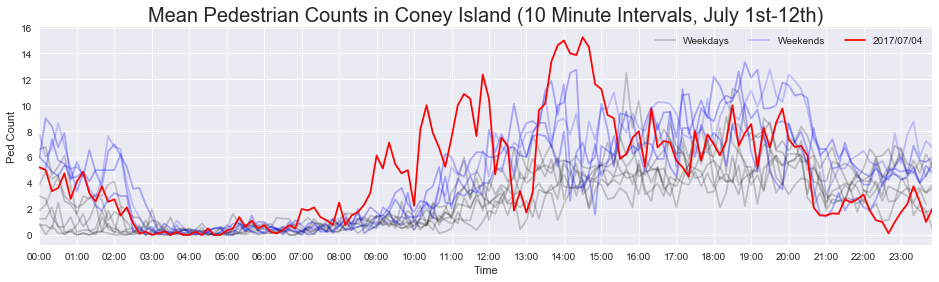

In [185]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(16, 4))

for d in [3,5,6,7,10,11,12]:
    day = peds[(peds.index.day == d) & (peds.cam_id == 856)]
    day_avg = pd.DataFrame(day.groupby(['cam_id', 'min10'])['count'].mean())
    day_avg = day_avg.unstack(1,)
    day_avg.columns = day_avg.columns.droplevel()
    day_avg.columns = range(len(day_avg.columns))
    day_avg = day_avg.T
    if d == 12:
        ax1.plot(day_avg.index, day_avg[856], label="Weekdays", c='k', alpha=0.2)
    else:
        ax1.plot(day_avg.index, day_avg[856], label="", c='k', alpha=0.2)

for d in [1,2,8,9]:
    day = peds[(peds.index.day == d) & (peds.cam_id == 856)]
    day_avg = pd.DataFrame(day.groupby(['cam_id', 'min10'])['count'].mean())
    day_avg = day_avg.unstack(1,)
    day_avg.columns = day_avg.columns.droplevel()
    day_avg.columns = range(len(day_avg.columns))
    day_avg = day_avg.T
    if d == 9:
        ax1.plot(day_avg.index, day_avg[856], label="Weekends", c='b', alpha=0.2)
    else:
        ax1.plot(day_avg.index, day_avg[856], label="", c='b', alpha=0.3)
    
for d in [4]:
    day = peds[(peds.index.day == d) & (peds.cam_id == 856)]
    day_avg = pd.DataFrame(day.groupby(['cam_id', 'min10'])['count'].mean())
    day_avg = day_avg.unstack(1,)
    day_avg.columns = day_avg.columns.droplevel()
    day_avg.columns = range(len(day_avg.columns))
    day_avg = day_avg.T
    ax1.plot(day_avg.index, day_avg[856], label="2017/07/0{}".format(d), c='r')

ax1.set_title("Mean Pedestrian Counts in Coney Island (10 Minute Intervals, July 1st-12th)", fontsize=20)
ax1.set_xlabel("Time")
ax1.set_ylabel("Ped Count")
ax1.set_xticks(range(144)[0::6])
ax1.set_xticklabels(map(lambda x: x.strftime("%H:%M"), pd.to_datetime(np.linspace(pd.Timestamp('2017-07-08').value, pd.Timestamp('2017-07-09').value, 145))[0::6]))
ax1.set_xlim(0, 143)
ax1.legend(ncol=3)

# E Houston

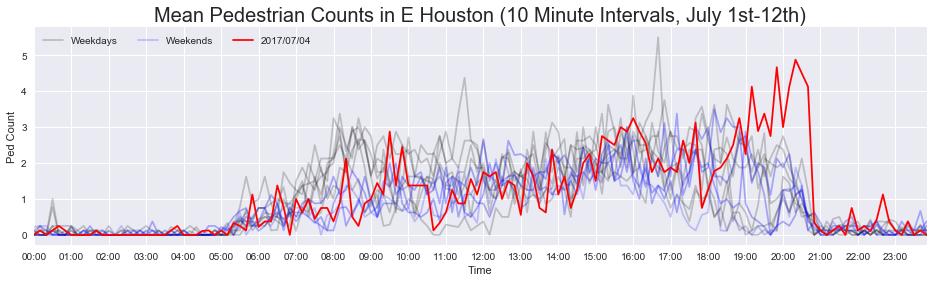

In [292]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(16, 4))

for d in [3,5,6,7,10,11,12]:
    day = peds[(peds.index.day == d) & (peds.cam_id == 791)]
    day_avg = pd.DataFrame(day.groupby(['cam_id', 'min10'])['count'].mean())
    day_avg = day_avg.unstack(1,)
    day_avg.columns = day_avg.columns.droplevel()
    day_avg.columns = range(len(day_avg.columns))
    day_avg = day_avg.T
    if d == 12:
        ax1.plot(day_avg.index, day_avg[791], label="Weekdays", c='k', alpha=0.2)
    else:
        ax1.plot(day_avg.index, day_avg[791], label="", c='k', alpha=0.2)

for d in [1,2,8,9]:
    day = peds[(peds.index.day == d) & (peds.cam_id == 791)]
    day_avg = pd.DataFrame(day.groupby(['cam_id', 'min10'])['count'].mean())
    day_avg = day_avg.unstack(1,)
    day_avg.columns = day_avg.columns.droplevel()
    day_avg.columns = range(len(day_avg.columns))
    day_avg = day_avg.T
    if d == 9:
        ax1.plot(day_avg.index, day_avg[791], label="Weekends", c='b', alpha=0.2)
    else:
        ax1.plot(day_avg.index, day_avg[791], label="", c='b', alpha=0.3)
    
for d in [4]:
    day = peds[(peds.index.day == d) & (peds.cam_id == 791)]
    day_avg = pd.DataFrame(day.groupby(['cam_id', 'min10'])['count'].mean())
    day_avg = day_avg.unstack(1,)
    day_avg.columns = day_avg.columns.droplevel()
    day_avg.columns = range(len(day_avg.columns))
    day_avg = day_avg.T
    ax1.plot(day_avg.index, day_avg[791], label="2017/07/0{}".format(d), c='r')

ax1.set_title("Mean Pedestrian Counts in E Houston (10 Minute Intervals, July 1st-12th)", fontsize=20)
ax1.set_xlabel("Time")
ax1.set_ylabel("Ped Count")
ax1.set_xticks(range(144)[0::6])
ax1.set_xticklabels(map(lambda x: x.strftime("%H:%M"), pd.to_datetime(np.linspace(pd.Timestamp('2017-07-08').value, pd.Timestamp('2017-07-09').value, 145))[0::6]))
ax1.set_xlim(0, 143)
ax1.legend(ncol=3)

# Union Square

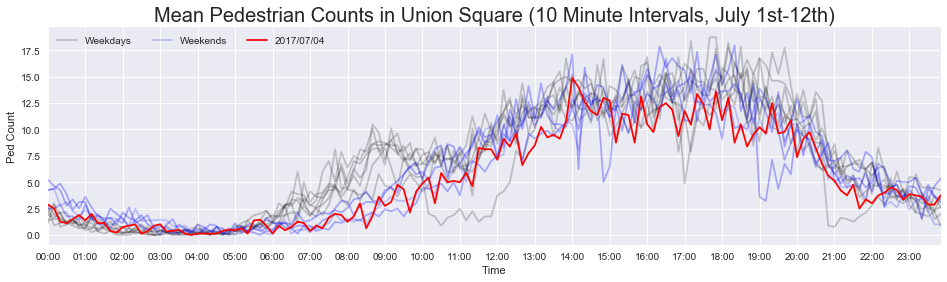

In [290]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(16, 4))

for d in [3,5,6,7,10,11,12]:
    day = peds[(peds.index.day == d) & (peds.cam_id == 535)]
    day_avg = pd.DataFrame(day.groupby(['cam_id', 'min10'])['count'].mean())
    day_avg = day_avg.unstack(1,)
    day_avg.columns = day_avg.columns.droplevel()
    day_avg.columns = range(len(day_avg.columns))
    day_avg = day_avg.T
    if d == 12:
        ax1.plot(day_avg.index, day_avg[535], label="Weekdays", c='k', alpha=0.2)
    else:
        ax1.plot(day_avg.index, day_avg[535], label="", c='k', alpha=0.2)

for d in [1,2,8,9]:
    day = peds[(peds.index.day == d) & (peds.cam_id == 535)]
    day_avg = pd.DataFrame(day.groupby(['cam_id', 'min10'])['count'].mean())
    day_avg = day_avg.unstack(1,)
    day_avg.columns = day_avg.columns.droplevel()
    day_avg.columns = range(len(day_avg.columns))
    day_avg = day_avg.T
    if d == 9:
        ax1.plot(day_avg.index, day_avg[535], label="Weekends", c='b', alpha=0.2)
    else:
        ax1.plot(day_avg.index, day_avg[535], label="", c='b', alpha=0.3)
    
for d in [4]:
    day = peds[(peds.index.day == d) & (peds.cam_id == 535)]
    day_avg = pd.DataFrame(day.groupby(['cam_id', 'min10'])['count'].mean())
    day_avg = day_avg.unstack(1,)
    day_avg.columns = day_avg.columns.droplevel()
    day_avg.columns = range(len(day_avg.columns))
    day_avg = day_avg.T
    ax1.plot(day_avg.index, day_avg[535], label="2017/07/0{}".format(d), c='r')

ax1.set_title("Mean Pedestrian Counts in Union Square (10 Minute Intervals, July 1st-12th)", fontsize=20)
ax1.set_xlabel("Time")
ax1.set_ylabel("Ped Count")
ax1.set_xticks(range(144)[0::6])
ax1.set_xticklabels(map(lambda x: x.strftime("%H:%M"), pd.to_datetime(np.linspace(pd.Timestamp('2017-07-08').value, pd.Timestamp('2017-07-09').value, 145))[0::6]))
ax1.set_xlim(0, 143)
ax1.legend(ncol=3)

# 3rd Ave & 42 St

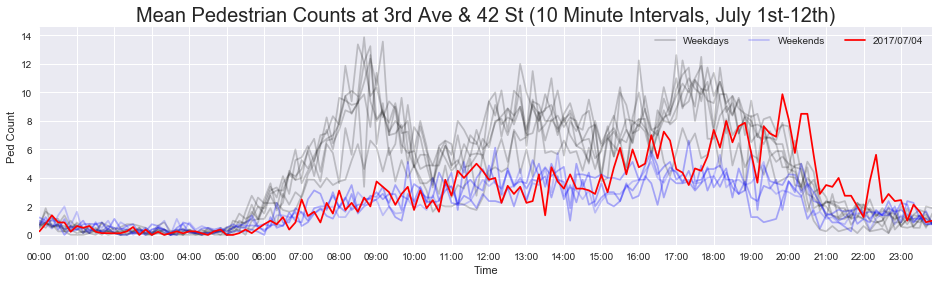

In [293]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(16, 4))

for d in [3,5,6,7,10,11,12]:
    day = peds[(peds.index.day == d) & (peds.cam_id == 398)]
    day_avg = pd.DataFrame(day.groupby(['cam_id', 'min10'])['count'].mean())
    day_avg = day_avg.unstack(1,)
    day_avg.columns = day_avg.columns.droplevel()
    day_avg.columns = range(len(day_avg.columns))
    day_avg = day_avg.T
    if d == 12:
        ax1.plot(day_avg.index, day_avg[398], label="Weekdays", c='k', alpha=0.2)
    else:
        ax1.plot(day_avg.index, day_avg[398], label="", c='k', alpha=0.2)

for d in [1,2,8,9]:
    day = peds[(peds.index.day == d) & (peds.cam_id == 398)]
    day_avg = pd.DataFrame(day.groupby(['cam_id', 'min10'])['count'].mean())
    day_avg = day_avg.unstack(1,)
    day_avg.columns = day_avg.columns.droplevel()
    day_avg.columns = range(len(day_avg.columns))
    day_avg = day_avg.T
    if d == 9:
        ax1.plot(day_avg.index, day_avg[398], label="Weekends", c='b', alpha=0.2)
    else:
        ax1.plot(day_avg.index, day_avg[398], label="", c='b', alpha=0.3)
    
for d in [4]:
    day = peds[(peds.index.day == d) & (peds.cam_id == 398)]
    day_avg = pd.DataFrame(day.groupby(['cam_id', 'min10'])['count'].mean())
    day_avg = day_avg.unstack(1,)
    day_avg.columns = day_avg.columns.droplevel()
    day_avg.columns = range(len(day_avg.columns))
    day_avg = day_avg.T
    ax1.plot(day_avg.index, day_avg[398], label="2017/07/0{}".format(d), c='r')

ax1.set_title("Mean Pedestrian Counts at 3rd Ave & 42 St (10 Minute Intervals, July 1st-12th)", fontsize=20)
ax1.set_xlabel("Time")
ax1.set_ylabel("Ped Count")
ax1.set_xticks(range(144)[0::6])
ax1.set_xticklabels(map(lambda x: x.strftime("%H:%M"), pd.to_datetime(np.linspace(pd.Timestamp('2017-07-08').value, pd.Timestamp('2017-07-09').value, 145))[0::6]))
ax1.set_xlim(0, 143)
ax1.legend(ncol=3)

# GIF

/Users/JordanVani/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


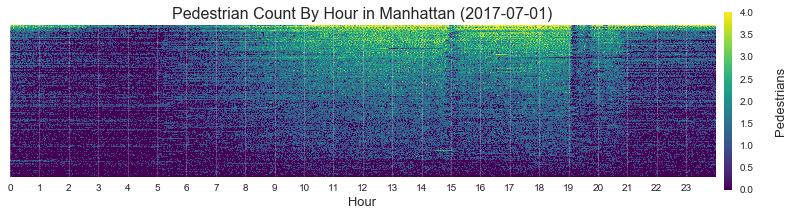

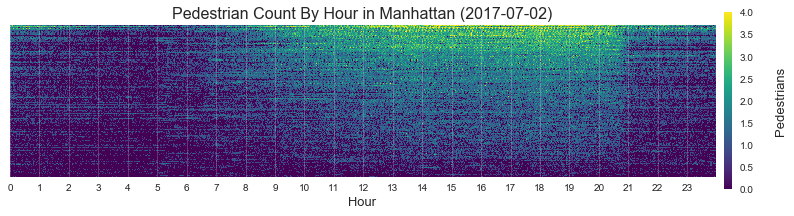

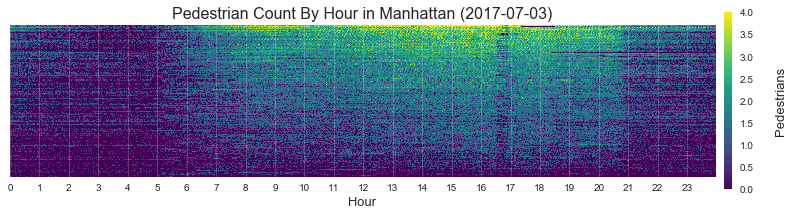

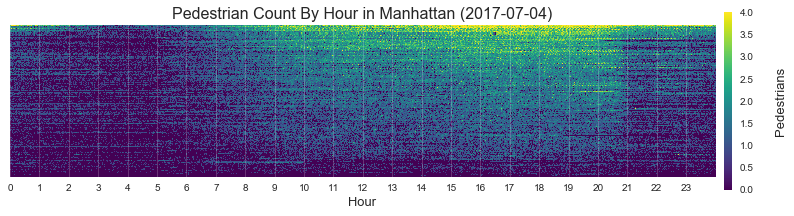

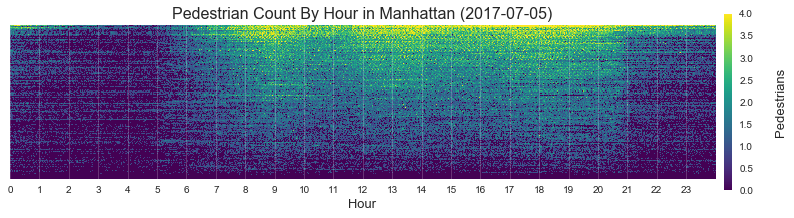

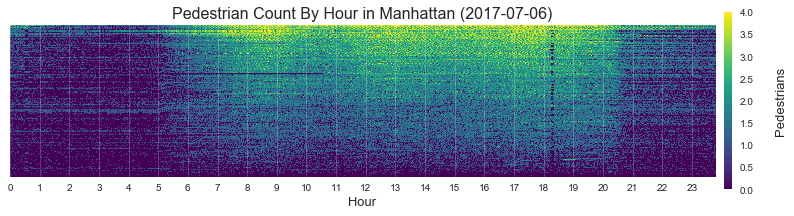

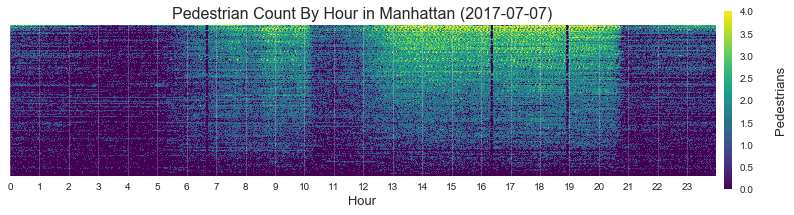

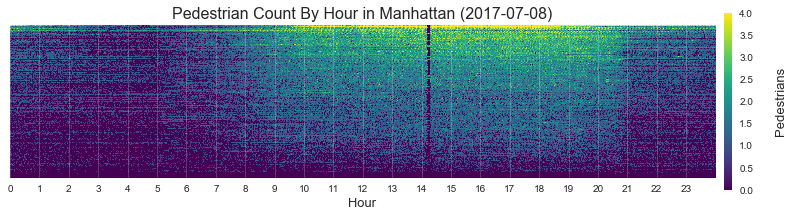

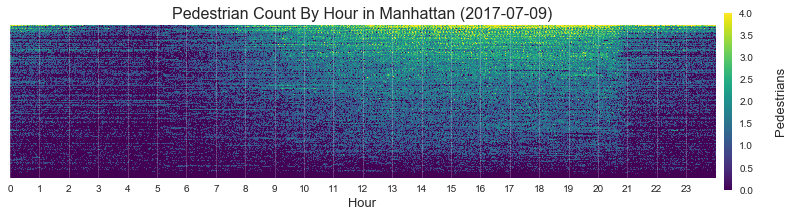

In [285]:
for i in range(1, 10):
    ts_data = peds[(peds.cam_id.isin(manhattan_cams.cam_id.unique())) & 
                   (peds.index < '2017-07-0{}'.format(i+1)) & (peds.index > '2017-07-0{}'.format(i))]

    ts_data.reset_index(inplace=True)
    ts_data['min2'] = ts_data.date.apply(lambda dt: datetime.datetime(
            1, 1, 1, dt.hour, 2*(dt.minute//2)))

    ts_data = ts_data.groupby(['cam_id', 'min2']).median()
    ts_data = ts_data.unstack(1,)
    ts_data.columns = ts_data.columns.droplevel()
    # ts_data = ts_data.T
    # ts_data = (ts_data-ts_data.min())/(ts_data.max()-ts_data.min())
    # ts_data = ts_data.T
    ts_data.columns = range(len(ts_data.columns))
    ts_data.T.fillna(method='bfill', inplace=True)
    ts_data = ts_data.merge(ts_data)
    ts_data['mean'] = ts_data.mean(axis=1)
    ts_data.sort_values('mean', inplace=True, ascending=False)
    ts_data.drop('mean', axis=1, inplace=True)
    ts_data = np.sqrt(ts_data)
    ts_data.dropna(inplace=True)

    fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(12, 3))
    im = ax1.imshow(ts_data, cmap='viridis', vmax=4)

    ax1.set_title('Pedestrian Count By Hour in Manhattan (2017-07-0{})'.format(i), fontsize=16)
    ax1.set_xlabel('Hour', fontsize=13)
    ax1.yaxis.set_label_position('right')
    ax1.set_ylabel('Pedestrians', fontsize=13, labelpad=60)
    ax1.set_xticklabels(range(24))
    ax1.set_xticks(np.arange(0, 720, 30))
    ax1.set_yticks([])
    cbar = fig.colorbar(im, ax=ax1, pad=0.01,)
#     cbar.ax.set_yticklabels([0, 1, 4, 9, 16, 25, 36])
    ax1.grid(alpha=0.2)
    fig.tight_layout()
    fig.savefig("{}.jpg".format(i))